In [ ]:
!pip install --ignore-requires-python git+https://github.com/IntelLabs/OSCAR
!pip install scipy torch-dct tqdm diffusers dotmap
!pip install git+https://github.com/mariusarvinte/score_sde_pytorch
!pip install torch==2.1.1 torchvision==0.16.1

Our work uses pretrained score-based diffusion models from CIFAR-10 from the following repo: https://github.com/yang-song/score_sde_pytorch#pretrained-checkpoints.
The code below will automatically download the exact subVP model variant that was used in the paper and place it in your current directory (for Google Colab this is `/content`).

In [ ]:
# Install Google Drive dependencies for automatic weight download
!python3 -m pip install gdown
!gdown "https://drive.google.com/uc?id=1bXoPbY28nReVIaNGutZfLzgS2uDK4k0I" -O "checkpoint_19.pth"

In [15]:
import torch, os
import numpy as np
import torch_dct as dct

from dotmap import DotMap
from torch.optim import Adam
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt

from score_sde_pytorch.models import utils as mutils
from score_sde_pytorch.models import ddpm, ncsnv2, ncsnpp # noqa: Needed to register models
from score_sde_pytorch.models.ema import ExponentialMovingAverage
from score_sde_pytorch.configs.subvp.cifar10_ddpmpp_deep_continuous import get_config as get_cifar10_ddpm_subvp_config
from score_sde_pytorch.utils import restore_checkpoint
from score_sde_pytorch.losses import get_optimizer

import score_sde_pytorch.sde_lib as sde_lib
import oscar.models.likelihood as likelihood

In [12]:
# Arguments
args = DotMap()
args.attack_type = 'near-sample' # ['near-sample', 'unrestricted', 'random-region', 'reverse']
args.adv_steps = 20 # Paper uses 500 steps for all attacks
args.adv_ode_step_size = 0.1 # Paper uses 0.05 for all attacks
args.adv_lr = 0.01
args.adv_hard_clip = 0.06 # [-epsilon, epsilon] interval for the perturbation
args.adv_high_freq_target = 10 # DCT high frequency maximization weight
args.global_seed = 2023

In [7]:
# Enable AMP and seed
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32       = True
torch.manual_seed(args.global_seed)
np.random.seed(args.global_seed)
torch.multiprocessing.set_sharing_strategy('file_system')

In [8]:
# Weight path
model_dir = '/content'
target_file = os.path.join(model_dir, 'checkpoint_19.pth')

config = get_cifar10_ddpm_subvp_config()
# Setup SDE exactly as it was trained on
sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, 
                       beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

# Get model and EMA object
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)
state = restore_checkpoint(target_file, state, config.device)
ema.copy_to(score_model.parameters())
score_model.cuda()
score_model.eval()

NCSNpp(
  (act): SiLU()
  (all_modules): ModuleList(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3-10): 8 x ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Dropout_0): Dropout(p=0.1, inplace=False)
      (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (11): ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): 

In [9]:
# Get likelihood solvers
epsilon = torch.randint(low=0, high=2, size=(1, 3, 32, 32), device='cuda').float() * 2 - 1.
shape = epsilon.shape

# Forward or reverse coarse-grid solver
if args.attack_type in ['unrestricted', 'near-sample', 'random-region']:
    timesteps = (1e-5, 1)
elif args.attack_type in ['reverse']:
    timesteps = (1, 1e-5)

# Get a checkpointed coarse-grid solver
likelihood_fn = likelihood.ODESolver(
    score_model, sde, method='rk4', eps=1e-5,
    ode_step_size=args.adv_ode_step_size, epsilon=epsilon, timesteps=timesteps, inverse_scaler=None,
    shape=epsilon.shape, adjoint_grads=False, is_differentiable=True)

# Get a stochastic fine-grid forward solver
stochastic_likelihood_fn = likelihood.ODESolver(
    score_model, sde, method='rk4', eps=1e-5, inverse_scaler=None,
    ode_step_size=0.001, epsilon=epsilon, shape=epsilon.shape, adjoint_grads=True)

In [10]:
# Get CIFAR-10 test data
dataset = CIFAR10('./data', train=False, transform=ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
in_iterator = iter(dataloader)

# Get a sample
samples, labels = next(in_iterator)
samples = samples.cuda()

# Get benign likelihoods (only for forward attacks)
with torch.no_grad():
    nll_benign = likelihood_fn(2*samples - 1)
print('Benign NLL', nll_benign)

Files already downloaded and verified
Benign NLL tensor([-4.6239], device='cuda:0')


In [13]:
# If we're targeting on-manifold attacks, start from samples
if args.attack_type == 'near-sample':
    attacked_patches = 2*samples - 1
elif args.attack_type == 'random-region':
    attacked_patches = 0.2 * torch.randn_like(samples)

# Initialize perturbation tensor and optimizer
z_adv = torch.normal(mean=0, std=0.1, size=epsilon.shape, requires_grad=True, device=epsilon.device)
optimizer = Adam(params=[z_adv], lr=args.adv_lr)

# For each adversarial step
with tqdm(total=args.adv_steps) as pbar:
    for step_idx in range(args.adv_steps):
        # Perturbed patch
        if args.attack_type in ['near-sample', 'random-region']:
            patch_adv = attacked_patches + z_adv # z_adv is already clamped at the end of the loop
        elif args.attack_type in ['unrestricted', 'reverse']:
            patch_adv = z_adv

        # Clamp and use passthrough approximation
        batch_samples = patch_adv + (torch.clamp(patch_adv, min=-1, max=1) - patch_adv).detach()
        
        # Get NLL
        if args.attack_type in ['near-sample', 'random-region', 'unrestricted']:
            nll_adv = likelihood_fn(batch_samples)
        elif args.attack_type in ['reverse']:
            # Reverse integration already negates NLL by flipping the integral limits
            nll_adv = -likelihood_fn(batch_samples)

        # Maximize NLL
        loss = -nll_adv
       
        # Get DCT of samples and minimize negative power of high frequencies
        adv_dct_loss = torch.zeros(1, device=samples.device)
        if args.adv_high_freq_target > 0:
            adv_dct = dct.dct_3d(patch_adv, norm='ortho')
            adv_dct_loss = -torch.sum(torch.square(adv_dct[..., 16:, 16:]), dim=(-1, -2, -3))
            loss = loss + args.adv_high_freq_target * adv_dct_loss

        # Sum across batch to preserve per-sample learning rate
        batch_loss = torch.sum(loss)
        
        # Push gradients and step optimizer
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Clamp perturbation to valid range
        if args.adv_hard_clip > 0:
            with torch.no_grad():
                # In-place clamping
                z_adv.clamp_(-args.adv_hard_clip, args.adv_hard_clip)

        # Update progressbar
        progress_dict = {'nll': nll_adv.cpu().detach().numpy(),
                         'dct_loss': adv_dct_loss.cpu().detach().numpy()}
        pbar.set_postfix(progress_dict)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [14:58<00:00, 44.95s/it, nll=[-1.3579253], dct_loss=[-17.052227]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Attacked, Fast NLL = -1.358')

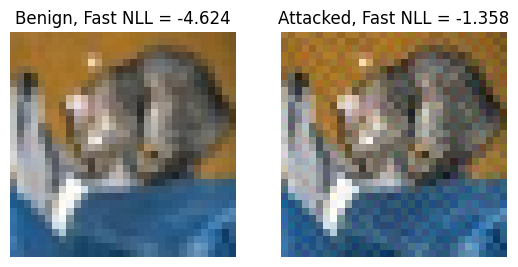

In [18]:
# Plot attack outcome
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(samples[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off')
plt.title('Benign, Fast NLL = %.3f' % nll_benign.item())

plt.subplot(1, 2, 2)
plt.imshow((patch_adv[0].permute(1, 2, 0).cpu().detach().numpy() + 1) / 2.); plt.axis('off')
plt.title('Attacked, Fast NLL = %.3f' % nll_adv.item())

In [ ]:
# Evaluate slow but accurate NLL of valid 8-bit pixel image using fine-grid solver
with torch.no_grad():
    patch_adv_clamped = torch.clamp(patch_adv.detach().clone(), min=-1, max=1)
    patch_adv_pixels = torch.round((patch_adv_clamped + 1) / 2. * 255.)
    patch_adv_pixels = 2 * patch_adv_pixels / 255. - 1.
    adv_nll_fine = stochastic_likelihood_fn(patch_adv_pixels)